In [1]:
cd /home/user1/Scripts/Python27/repos/aqs/

/home/user1/Scripts/Python27/repos/aqs


In [5]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandasql as ps
import glob
from dateutil import parser
from datetime import timedelta, date
import requests
import json

In [6]:
mesowest_api_key = "KzxxYow297burLSv2E54TEQhhrx7NQCfWR7"

In [7]:
start_date = date(2016, 1, 1)
end_date = date(2016, 12, 31)

In [8]:
 metrics = ["air_temp_set_1", "altimeter_set_1", "wind_speed_set_1", "relative_humidity_set_1", "precip_accum_24_hour_set_1"]

In [7]:
#--------------------READING AND PRE-PROCESSING DAILY AQS AND WEATHER DATA-------------------
#--------------------------------------------------------------------------------------------

data = pd.read_csv("data/daily_aqi_by_county_2016.csv")
states = pd.read_csv("data/States.csv")

# for i in range(2015, 2019):
#     data = pd.concat([data, pd.read_csv("data/daily_aqi_by_county_" + str(i) + ".zip")])    

In [11]:
counties_abbrev = pd.read_csv("counties_abbrev_Ian.csv")


ValueError: labels ['Unnamed: 0'] not contained in axis

In [12]:
counties_abbrev.columns = ["OrigIndex", "State", "County", "Abbreviation"]

In [14]:
# query = """SELECT DISTINCT `State Name`, `county Name` FROM data"""

# counties = ps.sqldf(query=query)

# counties.columns = ["State", "County"]

# counties_abbrev = pd.merge(counties, states, how="left", on="State")

counties_abbrev["State"] = counties_abbrev["State"].apply(str.strip)
counties_abbrev["County"] = counties_abbrev["County"].apply(str.strip)

counties_abbrev["is_city"] = 0

In [140]:
# Helper functions
def get_token(api_key):
    response = requests.get("https://api.mesowest.net/v2/auth?apikey=" + api_key)
    return json.loads(response.content.decode("latin1"))["TOKEN"]

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)
        
def get_avg_filt(dic, var):
    if isinstance(dic[var], dict):
        return dic[var]["average"]
    else:
        return np.nan
    
def get_avg(response, var):
    if "STATION" in response.keys():
        stations = response["STATION"]
        N = len(stations)
        if stations:
            return np.nanmean([get_avg_filt(y, var) for y in [x["STATISTICS"] for x in stations if "STATISTICS" in x.keys()] if var in y.keys()])
        else:
            return np.nan
    else:
        print("no STATION in keys")
        return np.nan
    
def run_api_query(url):
    t1 = time()
    response = requests.get(url)
    t2 = time()
    resp_json = json.loads(response.text)
    t3 = time()
#     print("Time for quering data from URL: {}".format(t2-t1))
#     print("Time for loading into json: {}".format(t3-t2))
    return resp_json

In [141]:
def run_mesowest_api(state_abbrev, county, year, month, day, token):
    date1 = str(year) + str(month).zfill(2) + str(day).zfill(2)
    date2 = str(year) + str(month).zfill(2) + str(day).zfill(2)
    is_city = counties_abbrev.loc[(counties_abbrev['County'] == county) & (counties_abbrev['Abbreviation'] == state_abbrev),"is_city"].values[0]
#     print(is_city)
    if(is_city):
        print("This county is actually a city. Querying by city...")
        url = "http://api.mesowest.net/v2/stations/statistics?state=" + state_abbrev + "&city=" + county + "&start=" + date1 + "0000&end=" + date2 + "0000&obtimezone=local&token=" + token + "&type=average"        
    else:
        url = "http://api.mesowest.net/v2/stations/statistics?state=" + state_abbrev + "&county=" + county + "&start=" + date1 + "0000&end=" + date2 + "0000&obtimezone=local&token=" + token + "&type=average"
    
    resp_json = run_api_query(url)
    
    if "STATION" in resp_json.keys():
        if resp_json["STATION"]:
            pass
        else:
            counties_abbrev.loc[(counties_abbrev['County'] == county) & (counties_abbrev['Abbreviation'] == state_abbrev),"is_city"].values[0] = 1
            print("No data found by county. Querying by city...")
            url = "http://api.mesowest.net/v2/stations/statistics?state=" + state_abbrev + "&city=" + county + "&start=" + date1 + "0000&end=" + date2 + "0000&obtimezone=local&token=" + token + "&type=average"        
            resp_json = run_api_query(url)

    return resp_json   

In [142]:
def get_county_weather_data(state, county, start_date, end_date, *argv):
    weather = dict()
    for arg in argv:
        weather[arg] = []
        
    dates = []   
    token = get_token(mesowest_api_key)
    
    for dt in daterange(start_date, end_date):
        response = run_mesowest_api(state, county, dt.year, dt.month, dt.day, token)
        dates.append(dt)
        t1 = time()
        for var in argv:            
            weather[var] += [get_avg(response, var)]
        t2 = time()
#         print("Finished pulling data for date {}. \nTime taken: {}".format(dt,t2-t1))
        
    weather_df = pd.DataFrame(weather)
    weather_df["Date"] = dates
    weather_df["State"] = state
    weather_df["County"] = county
    
    return weather_df

In [143]:
temp = pd.DataFrame()
for i in range(len(counties_abbrev)):  
    county_name = counties_abbrev["County"][i].replace(" ", "%")
    if isinstance(counties_abbrev["Abbreviation"][i], str) & isinstance(counties_abbrev["County"][i], str):
        print("\nGetting weather data for county {} - {}".format(counties_abbrev["OrigIndex"][i], county_name))  
        temp_upd = get_county_weather_data(counties_abbrev["Abbreviation"][i], counties_abbrev["County"][i].replace(" ", "%"), start_date, end_date, "air_temp_set_1", "altimeter_set_1", "wind_speed_set_1", "relative_humidity_set_1", "precip_accum_24_hour_set_1")
        temp = pd.concat([temp, temp_upd])
    else:
        print("Skipping county {} - {}".format(i,county_name))
        continue


Getting weather data for county 0 - Baldwin

Getting weather data for county 1 - Clay
No data found by county. Querying by city...
No data found by county. Querying by city...

Getting weather data for county 2 - Colbert


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice



Getting weather data for county 3 - DeKalb

Getting weather data for county 4 - Elmore
No data found by county. Querying by city...

Getting weather data for county 5 - Etowah
No data found by county. Querying by city...
No data found by county. Querying by city...

Getting weather data for county 6 - Houston

Getting weather data for county 7 - Jefferson

Getting weather data for county 8 - Lawrence

Getting weather data for county 9 - Madison


KeyboardInterrupt: 

In [41]:
temp.reset_index(drop=True,inplace=True)
# temp
temp.to_csv("weather_data.csv", index=None,header=True)

In [10]:
def missing_density(data, var):
    return (data[var].isnull()).sum()/data.shape[0]

In [11]:
missing_density(temp, "altimeter_set_1")

NameError: name 'temp' is not defined

In [341]:
[x["STATISTICS"] for x  in response["STATION"]]

get_temp("NC", "Wake", start_date, end_date, "air_temp_set_1", "altimeter_set_1")

2016-04-02


,air_temp_set_1,altimeter_set_1,Date,State,County
0,22.2,100220.12,2016-04-02,NC,Wake


In [66]:
import matplotlib.pyplot as plt


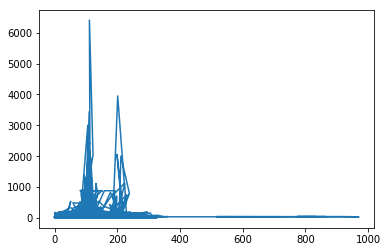

In [68]:
plt.plot(data["Average Windspeed"],data["AQI"]);plt.show()

In [28]:
data

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2014-01-02,33,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2014-01-05,29,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2014-01-08,29,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2014-01-11,15,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2014-01-14,22,Good,PM2.5,01-003-0010,1
5,Alabama,Baldwin,1,3,2014-01-17,18,Good,PM2.5,01-003-0010,1
6,Alabama,Baldwin,1,3,2014-01-20,39,Good,PM2.5,01-003-0010,1
7,Alabama,Baldwin,1,3,2014-01-23,39,Good,PM2.5,01-003-0010,1
8,Alabama,Baldwin,1,3,2014-01-26,45,Good,PM2.5,01-003-0010,1
9,Alabama,Baldwin,1,3,2014-01-29,26,Good,PM2.5,01-003-0010,1
